In [1]:
from dataloader import CircleDataset, CircleRaw
from model import FeatupExtra
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from polygon import RasLoss
from ModelInfer import ModelInfer

In [2]:
raw_set = CircleRaw()
data_set = CircleDataset()
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)

In [3]:
extra_encoder = nn.Sequential(
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
)
model = FeatupExtra(extra_encoder=extra_encoder).cuda()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [4]:
model_infer = ModelInfer(raw_set)

In [5]:
model_infer.infer_model(model)

/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


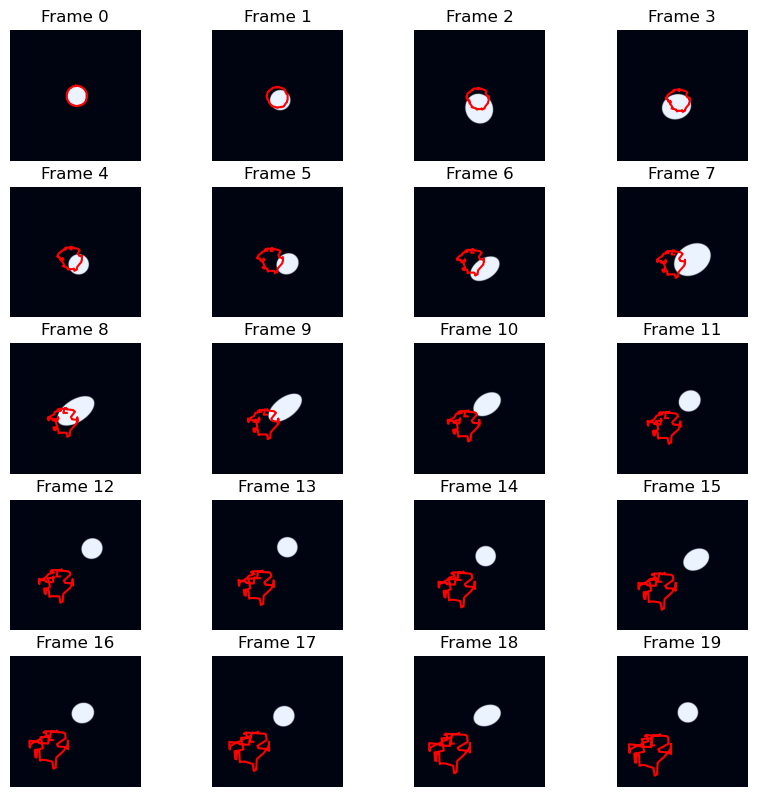

tensor(0.1588)

In [6]:
model_infer.show_infer_result(0)

In [10]:
extra_encoder = nn.Sequential(
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
    nn.Conv2d(
        in_channels=384,
        out_channels=384,
        kernel_size=3,
        padding=1,
        stride=1,
    ),
    nn.ReLU(),
)
model = FeatupExtra(extra_encoder=extra_encoder).cuda()
model_infer = ModelInfer(raw_set)
ras_loss = RasLoss()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/ras/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
dict_loss = {}
dict_iou = {}
interval_epochs = 150
inter_num = 47
epoch_index = 0
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

Epoch 0 Loss: 1.0062830824601023
Epoch 1 Loss: 0.9649413118236944
Epoch 2 Loss: 0.957726251137884
Epoch 3 Loss: 0.9332544097774907
Epoch 4 Loss: 0.9011416811692087
Epoch 5 Loss: 0.8696007289384541
Epoch 6 Loss: 0.8263264643518549
Epoch 7 Loss: 0.8169445458211397
Epoch 8 Loss: 0.7855716739830217
Epoch 9 Loss: 0.8549894612086447
Epoch 10 Loss: 0.7240662715936962
Epoch 11 Loss: 0.7459449266132555
Epoch 12 Loss: 0.6768695476808047
Epoch 13 Loss: 0.6890255542177903
Epoch 14 Loss: 0.6343964714753
Epoch 15 Loss: 0.6139458182610964
Epoch 16 Loss: 0.5922478170771348
Epoch 17 Loss: 0.6089032496276655
Epoch 18 Loss: 0.5471270602000388
Epoch 19 Loss: 0.5304532443222246
Epoch 20 Loss: 0.48847152292728424
Epoch 21 Loss: 0.48753655113671956
Epoch 22 Loss: 0.5059166974142978
Epoch 23 Loss: 0.5364804267883301
Epoch 24 Loss: 0.48639716443262604
Epoch 25 Loss: 0.548061014790284
Epoch 26 Loss: 0.502367670598783
Epoch 27 Loss: 0.4590168971764414
Epoch 28 Loss: 0.47461515272918503
Epoch 29 Loss: 0.422314442

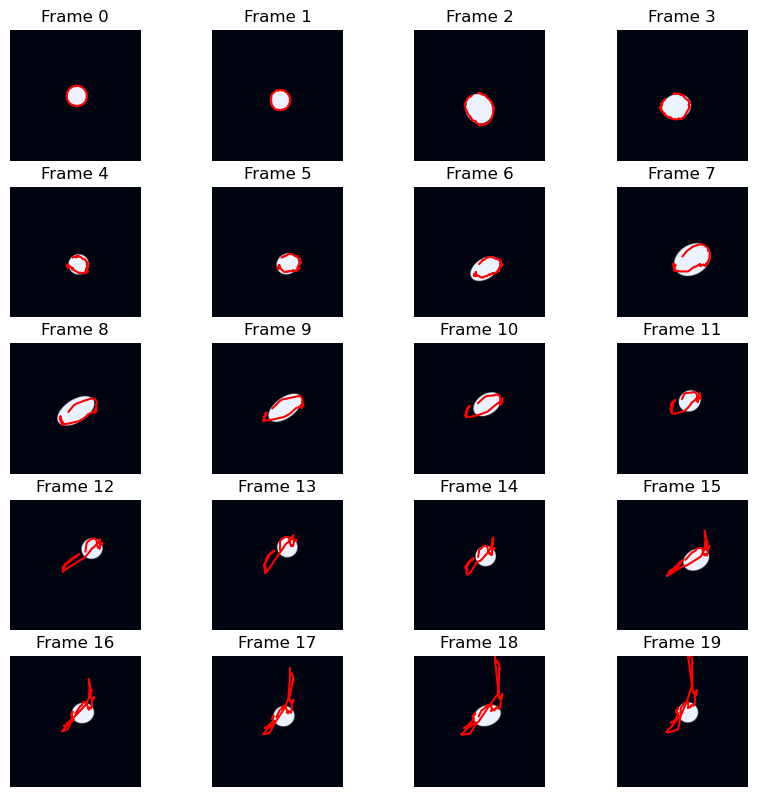

Epoch 150 IoU: 0.5341814756393433


In [12]:
for interval in range(inter_num):
    for e in range(interval_epochs):
        model.train()
        mean_loss = 0
        for (
            pre_idx,
            fir_img,
            fir_sgm,
            fir_bou,
            pre_img,
            pre_sgm,
            pre_bou,
            cur_img,
            cur_sgm,
            cur_bou,
        ) in data_loader:
            pre_idx = pre_idx.item()
            pre_bou = model_infer.get_boundary(pre_idx)
            pre_bou = pre_bou.unsqueeze(0).cuda()
            optimizer.zero_grad()
            results = model(
                fir_img.cuda(),
                fir_bou.cuda(),
                pre_img.cuda(),
                cur_img.cuda(),
                pre_bou.cuda(),
            )
            refine_num = len(results)
            loss = 0
            for i in range(refine_num):
                loss += 0.8 ** (refine_num - i - 1) * ras_loss(
                    results[i], cur_sgm.cuda()
                )
            loss.backward()
            optimizer.step()
            mean_loss += loss.item()
        mean_loss /= len(data_loader)
        print(f"Epoch {epoch_index} Loss: {mean_loss}")
        dict_loss[epoch_index] = mean_loss
        epoch_index += 1
    model_infer.infer_model(model)
    total_iou = model_infer.get_infer_iou(0)
    model_infer.show_infer_result(0)
    dict_iou[epoch_index] = total_iou
    print(f"Epoch {epoch_index} IoU: {total_iou}")
    break
    if interval_epochs > 20:
        interval_epochs -= 10